In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataDir='./drive/MyDrive/input/val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "./drive/MyDrive/input/img"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [ ]:
# display categories and supercategories

#Single Class #Damage dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories for damages: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories for damages: \n{}\n'.format(', '.join(nms)))

#Multi Class #Parts dataset

mul_cats = mul_coco.loadCats(mul_coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))

mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))

COCO categories for damages: 
damage

COCO supercategories for damages: 
part

COCO categories for parts: 
headlamp, rear_bumper, door, hood, front_bumper

COCO supercategories for parts: 
part



In [ ]:
# get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['damage']);
imgIds = coco.getImgIds(catIds=catIds );

In [ ]:
random_img_id = random.choice(imgIds)
print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

1 image id was selected at random from the [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] list


In [ ]:
# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

Image details 
 {'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '22.jpg', 'flickr_url': '', 'height': 1024, 'id': 1, 'license': 1, 'width': 1024}


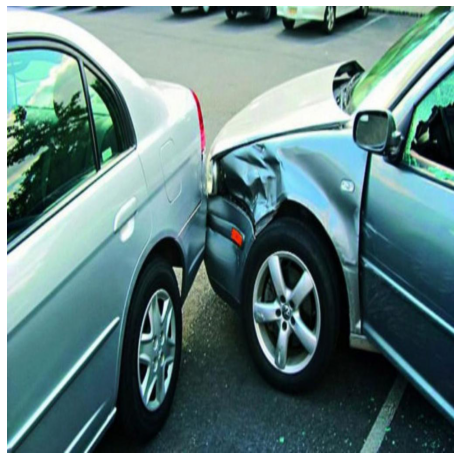

In [ ]:
I = io.imread(img_dir + '/' + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)

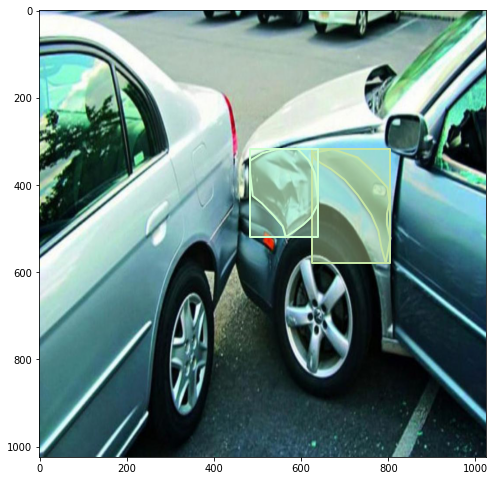

In [ ]:
#Plot damages
plt.imshow(I)
plt.axis('on')
coco.showAnns(anns, draw_bbox=True )

In [ ]:
#get parts annotations
mul_annIds = mul_coco.getAnnIds(imgIds=imgId,iscrowd=None)
mul_anns = mul_coco.loadAnns(mul_annIds)

In [ ]:
# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(mul_coco.cats.values()):
    category_map.update({ele['id']:ele['name']})

In [ ]:
category_map

{1: 'headlamp', 2: 'rear_bumper', 3: 'door', 4: 'hood', 5: 'front_bumper'}

Parts are: ['door', 'rear_bumper', 'headlamp', 'headlamp', 'hood', 'front_bumper', 'door']


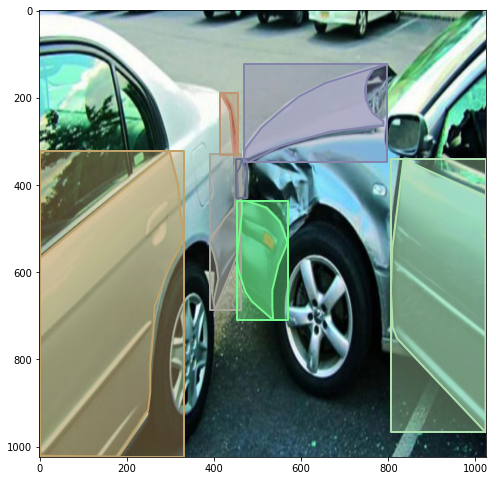

In [ ]:
#Create a list of parts in the image
parts = []
for region in mul_anns:
    parts.append(category_map[region['category_id']])

print("Parts are:", parts) 

#Plot Parts
I = io.imread(img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('on')
mul_coco.showAnns(mul_anns, draw_bbox=True )

Training Object detection model using Detectron2

In [ ]:
!pip uninstall torch
!pip unistall torchvision
!pip install torch==1.7.0 torchvision==0.8.1 torchaudio==0.7.0
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

In [ ]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

In [ ]:
!python -m detectron2.utils.collect_env

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

ModuleNotFoundError: ignored

In [ ]:
dataset_dir = "./drive/MyDrive/input/"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"
test_dri = "test/"

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_train", {}, os.path.join(dataset_dir,train_dir,"COCO_train_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))

In [ ]:
dataset_dicts = DatasetCatalog.get("car_dataset_train")
metadata_dicts = MetadataCatalog.get("car_dataset_train")

In [ ]:
#Implementing my own Trainer Module here to use the COCO validation evaluation during training
# TODO: add data custom augmentation 
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dataset_train",)
cfg.DATASETS.TEST = ("car_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 800
cfg.SOLVER.MAX_ITER = 1600 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (600, 1550)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this  dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 1 # only has one class (damage) + 1
cfg.TEST.EVAL_PERIOD = 600



# Clear any logs from previous runs
#TODO add timestamp to logs
!rm -rf cfg.OUTPUT_DIR


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
def smooth(scalars, weight=0.6):
    """
    Reference: https://github.com/plotly/dash-live-model-training/blob/master/app.py#L163
    """
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


def plot(logdir: str, savedir: str, smoothing: float = 0.6, no_title=False, no_legend=False, no_axis_labels=False):
    """ re-draw the tf summary events plots  using seaborn
    :param logdir: Path to the directory having event logs
    :param savedir: Path to save the seaborn graphs
    :param smoothing: smoothing window space for the plots
    """
    assert 0 <= smoothing <= 1, 'Smoothing value should be in [0,1]'
    
    plots = []
    
    sns.set(style="darkgrid")
    sns.set_context("paper")

    # Collect data
    # we recognize all files which have tfevents
    scalars_info = {}
    for root, dirs, files in os.walk(logdir):
        for event_file in [x for x in files if 'tfevents' in x]:
            event_path = os.path.join(root, event_file)

            acc = ea.EventAccumulator(event_path)
            acc.Reload()

            # only support scalar now
            scalar_list = acc.Tags()['scalars']
            for tag in scalar_list:
                x = [s.step for s in acc.Scalars(tag)]
                y = [s.value for s in acc.Scalars(tag)]
                data = {'x': x, 'y': y, 'legend': root.split(logdir)[1][1:] if root != logdir else None}
                if tag not in scalars_info:
                    scalars_info[tag] = [data]
                else:
                    scalars_info[tag].append(data)

    # We recognize groups assuming each group name has /
    # And, each group is saved in a separate directory
    for tag, tag_data in scalars_info.items():
        _split = tag.split('/')
        if len(_split) <= 1:
            _path = os.path.join(savedir, 'seaborn')
            _name = _split[0]
        else:
            _path = os.path.join(savedir, 'seaborn', _split[0])
            _name = ''.join(_split[1:])

        os.makedirs(_path, exist_ok=True)

        color_list = list(sns.color_palette(palette='dark', n_colors=len(tag_data)))[::-1]
        for data in tag_data:
            x, y = data['x'], data['y']
            y_smooth = smooth(y, weight=smoothing)
            current_color = color_list.pop()
            _plt = sns.lineplot(x, y, color=colors.to_rgba(current_color, alpha=0.4))
            _legend = data['legend'] if not no_legend else None
            _plt = sns.lineplot(x, y_smooth, label=data['legend'], color=current_color)

        if not no_axis_labels:
            _plt.set(xlabel='x', ylabel='y')
        if not no_title:
            _plt.set_title(_name.capitalize())
        
        plots.append(os.path.join(_path, _name + '.png'))
        plt.savefig(os.path.join(_path, _name + '.png'))
        plt.clf()
    return plots

In [ ]:
plots = plot(logdir= './output', savedir= './')

In [ ]:
plots

In [ ]:
my_dpi = 1000
fig, ax = plt.subplots(4,1, figsize = (12,10), dpi=my_dpi)


ax[0].set_title('Total Loss', fontsize=12)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(Image.open('./seaborn/total_loss.png'))

ax[1].set_title('Bounding Box Average Precision', fontsize=12)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(Image.open('./seaborn/bbox/AP.png'))

ax[2].set_title('Segmentation Average Precision', fontsize=12)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].imshow(Image.open('./seaborn/segm/AP.png'))

ax[3].set_title('Class accuracy', fontsize=12)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].imshow(Image.open('./seaborn/fast_rcnn/cls_accuracy.png'))

In [ ]:
evaluator = COCOEvaluator("car_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car_dataset_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

NameError: ignored

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("car_dataset_val", )
predictor = DefaultPredictor(cfg)

NameError: ignored

In [ ]:
val_dataset_dicts = DatasetCatalog.get("car_dataset_val")
val_metadata_dicts = MetadataCatalog.get("car_dataset_val")

[11/09 08:10:06 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./drive/MyDrive/input/val/COCO_val_annos.json


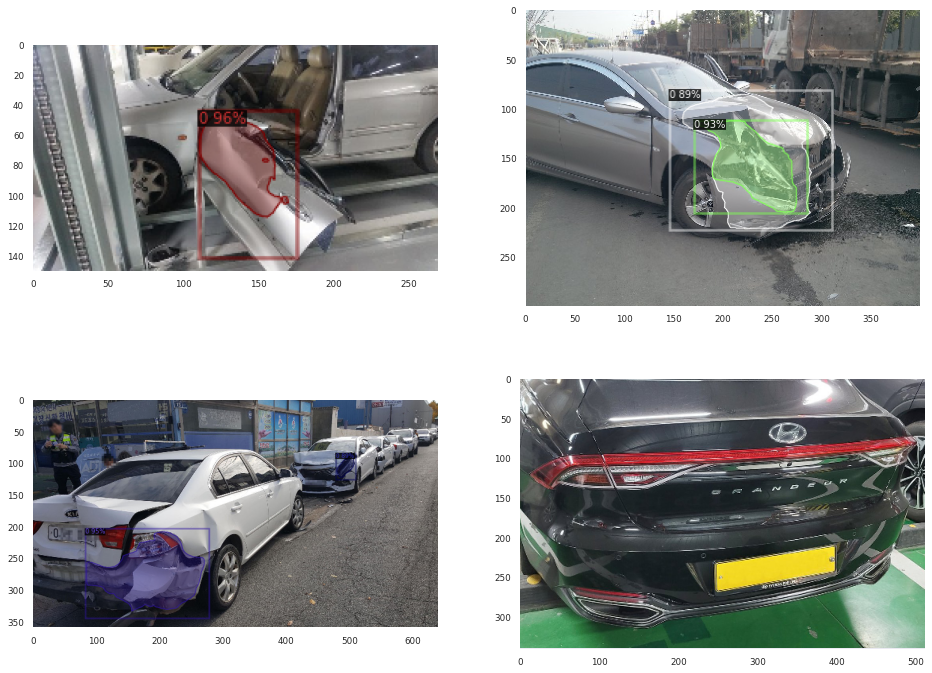

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(16,12))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1]]
i=-1
test_image_names = ["./drive/MyDrive/input/frontdoor.jpg","./drive/MyDrive/input/damage1.jpg","./drive/MyDrive/input/damage2.jpeg","./drive/MyDrive/input/normal2.jpg"]
for d in test_image_names:
    i=i+1    
    #val_image_name = d["file_name"]
   
    im = io.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(16,12))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(val_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

NameError: ignored

In [ ]:
!python --version

Python 3.7.15
